<a href="https://colab.research.google.com/github/teymour-aldridge/NN/blob/master/computer_vision/pix2pix/cityscapes/pix2pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os, glob
import skimage
from skimage import io
import functools

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim

import torchvision
from torchvision import transforms
from torch.utils import data

import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator

In [0]:
def downsample(in_channels, out_channels, kernel_size=4, padding=1, apply_batchnorm=True, stride=2):
  model = []
  model.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride, bias=False))
  if apply_batchnorm:
    model.append(nn.BatchNorm2d(out_channels))
  model.append(nn.LeakyReLU())
  model = nn.Sequential(*model)
  return model

def upsample(in_channels, out_channels, kernel_size=4, padding=1, stride=2, apply_dropout=False):
  model = []
  model.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride))
  model.append(nn.BatchNorm2d(out_channels))
  if apply_dropout:
    model.append(nn.Dropout(0.5))
  model.append(nn.ReLU())
  model = nn.Sequential(*model)
  return model

In [0]:
class Generator(nn.Module):
  def __init__(self):
    """
    The generator module first downsamples (to a lower dimensionality) and then
    upsamples again (to a higher dimensionality). This is a type of Encoder => Decoder
    architecture, where the decoder creates a lower dimensionality version of the 
    input which the encoder tries to reconstruct, minimising a loss function. Note
    that the encoder doesn't try to reconstruct the data as it was when input to the
    decoder, but instead it will be trained to reconstruct them as the 
    """
    super(Generator, self).__init__()
    self.down_stack = [
      downsample(3, 64, apply_batchnorm=False),
      downsample(64, 128),
      downsample(128, 256),
      downsample(256, 512),
      downsample(512, 512),
      downsample(512, 512),
      downsample(512, 512),
    ]
    self.up_stack = [
      upsample(512, 512),
      upsample(512, 512),
      upsample(512, 512),
      upsample(512, 256),
      upsample(256, 128),
      upsample(128, 64),
    ]
    self.last = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2)
  def forward(self, x):
    
    skips = []

    for layer in self.down_stack:
      x = layer(x)
      skips.append(x)
    
    # The skips need to be reversed
    skips = reversed(skips[:-1])
    for i, (layer, skip) in enumerate(zip(self.up_stack, skips)):
      x = layer(x)
      
    x = torch.tanh(self.last(x))
    
    # Ensure correct output size
    x = F.upsample(x, size=(256,256))
    
    return x

## Test generator

In [11]:
g = Generator()
len(g.up_stack)

6

In [12]:
g.apply(weights_init)
x = g(torch.rand(4, 3, 256, 256))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


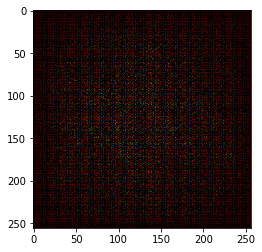

In [13]:
plt.imshow(x.detach()[3].squeeze().permute(2, 1, 0))

# Build discriminator

In [0]:
real_label = 1
fake_label = 0

class Discriminator(nn.Module):
  def __init__(self, kernel_size):
    super(Discriminator, self).__init__()
    self.kernel_size = kernel_size
    self.conv1 = downsample(3, 64)
    self.conv2 = downsample(64, 128)
    self.conv3 = downsample(128, 256)
    self.conv4 = downsample(256, 512)
    self.conv5 = downsample(512, 512)
    self.conv6 = downsample(512, 512)
    self.conv7 = downsample(512, 512)
    self.conv8 = downsample(512, 1)
  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = self.conv6(x)
    x = self.conv7(x)
    x = self.conv8(x)
    return F.sigmoid(x)

In [0]:
x = torch.rand(4, 3, 256, 256)

In [16]:
d = Discriminator(4)
d.apply(weights_init)
x = d(x)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [17]:
x.shape

torch.Size([4, 1, 1, 1])

In [18]:
x.squeeze()

tensor([0.8168, 0.4993, 0.4969, 0.5079], grad_fn=<SqueezeBackward0>)

# Dataset

In [0]:
base_path = '/content/gdrive/My Drive/Computing/ML/Computer Vision/pix2pix/image_segmentation/cityscapes_data'

class ImageDataset(data.Dataset):
  def __init__(self, base_path, train=True, transform=None):
    self.base_path = os.path.join(base_path, "train" if train else "val")
    self.index = glob.glob(self.base_path + '/*.jpg')
    print(self.base_path + '*.jpg')
    if transform:
      transform.__call__
    self.transform = transform
  def __getitem__(self, idx):
    img = io.imread(self.index[idx])
    # Crop images
    input = img[:, :256]
    target = img[:, 256:]
    # Rotate images
    input = torchvision.transforms.functional.rotate(transforms.ToPILImage()(input), 90)
    target = torchvision.transforms.functional.rotate(transforms.ToPILImage()(target), 90)
    if self.transform:
      input = torch.FloatTensor(self.transform(input))
      target = torch.FloatTensor(self.transform(target))
    return input, target
  def __len__(self):
    return len(self.index)

In [21]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = ImageDataset(base_path, transform=transform)
print(len(train_dataset))
dataloader = data.DataLoader(train_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

/content/gdrive/My Drive/Computing/ML/Computer Vision/pix2pix/image_segmentation/cityscapes_data/train*.jpg
2975


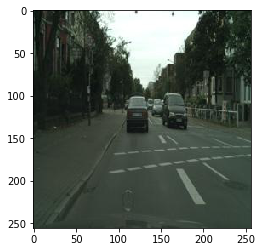

In [22]:
plt.imshow(train_dataset[0][0].permute((2, 1, 0)))

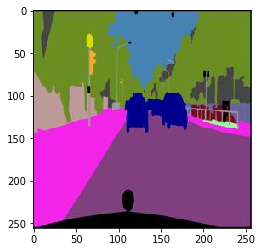

In [23]:
plt.imshow(train_dataset[0][1].permute((2, 1, 0)))

In [0]:
for i, item in enumerate(dataloader):
  if i > 0:
    break

In [25]:
len(item)

2

# Training

In [0]:
g.to(device)
d.to(device)

g_optim = optim.Adam(g.parameters())
d_optim = optim.Adam(d.parameters())

In [33]:
LAMBA = 100

for input, target in dataloader:
  input.to(device)
  target.to(device)
  # Prevent accumulation of gradients
  g.zero_grad()
  d.zero_grad()
  real_images = target
  # Generate the fake images
  fake_images = g(target)
  # 1. Compute the fake image loss
  fake_output = d(fake_images)
  fake_loss = loss_fn(fake_output, torch.zeros_like(fake_output))
  # 2. Compute the real image loss
  real_output = d(real_images)
  real_loss = loss_fn(real_output, torch.ones_like(real_output))
  
  total_discriminator_loss = real_loss + fake_loss
  total_discriminator_loss.backward()
  g_optim.step()
  
  loss_from_discriminator = loss_fn(fake_output, torch.ones_like(real_output))
  # Calculate the distance between the target and the actual
  l1_loss = torch.mean(torch.abs(target - fake_images))
  
  total_generator_loss = loss_from_discriminator + (l1_loss * LAMBDA)

RuntimeError: ignored